In [1]:
import os
import sys
import random

import copy 
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime as dt
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2

In [2]:
import segmentation_models as sm

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [3]:
from tensorflow.keras import backend as K

In [4]:
import pydicom as dicoms

In [5]:
sm.set_framework('tf.keras')

In [6]:
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [7]:
train_path = r"J:\yasin\finalData"
checkPoint=r"J:\yasin\finalData\backup"
batch_size = 8
data = pd.read_csv(r"J:\yasin\finalData\train.csv")

In [8]:
data

,Unnamed: 0,patient,dicom_path,mask_path,size
0,0,abdullah_celik,finalData\img\abdullah_celik\56.jpg,finalData\mask\abdullah_celik\56.jpg,17641
1,1,Ahmet_Ozturk,finalData\img\Ahmet_Ozturk\28.jpg,finalData\mask\Ahmet_Ozturk\28.jpg,24082
2,2,Ahmet_Ozturk,finalData\img\Ahmet_Ozturk\29.jpg,finalData\mask\Ahmet_Ozturk\29.jpg,25368
3,3,Ahmet_Ozturk,finalData\img\Ahmet_Ozturk\30.jpg,finalData\mask\Ahmet_Ozturk\30.jpg,25961
4,4,ahmet_tamturk,finalData\img\ahmet_tamturk\18.jpg,finalData\mask\ahmet_tamturk\18.jpg,13545
...,...,...,...,...,...
338,338,Yilmaz_Tek,finalData\img\Yilmaz_Tek\46.jpg,finalData\mask\Yilmaz_Tek\46.jpg,36721
339,339,Yilmaz_Tek,finalData\img\Yilmaz_Tek\47.jpg,finalData\mask\Yilmaz_Tek\47.jpg,38514
340,340,Yilmaz_Tek,finalData\img\Yilmaz_Tek\80.jpg,finalData\mask\Yilmaz_Tek\80.jpg,9288
341,341,Zehra_Yavuz,finalData\img\Zehra_Yavuz\47.jpg,finalData\mask\Zehra_Yavuz\47.jpg,22916


In [19]:
class DataGen(keras.utils.Sequence):
    def __init__(self, data, shuffle = False, batch_size=16,
                 image_size = 512,
                 preprocess=None, info={}):
        self.data = data               
        self.batch_size = batch_size 
        self.image_size = image_size        
        self.preprocess = preprocess        
        self.shuffle = shuffle              
        self.on_epoch_end()
        
    def __getitem__(self, index):
        images = []
        masks  = []        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        raw= self.data.iloc[indexes]
        for i,row in raw.iterrows(): 
            try:
#                 d_filepath=row["dicom_path"]               
                seg =cv2.imread(row["dicom_path"] , 1)                
#                 seg = cv2.resize(seg, (self.image_size , self.image_size))             
#                 seg=scaler.fit_transform(seg)
                images.append(seg)
                mask=cv2.imread(row["mask_path"], 1)
                mask = cv2.resize(mask, (self.image_size , self.image_size ))
                masks.append(mask)
            except Exception as e:                
                print(e)
        
        images = np.array(images)
        masks  = np.array(masks)
        
        if self.preprocess!=None: images = self.preprocess(images)
        
        return images,masks
        
    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)



In [10]:
image_size=256

In [11]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
model = sm.Unet(BACKBONE,input_shape=(image_size, image_size, 1), 
                encoder_weights=None, activation='sigmoid')
#                 classes=1, activation='softmax')

In [20]:
data = data.sample(frac=1).reset_index(drop=True)
idx = int(0.8*len(data))
train_gen = DataGen(data.iloc[:idx], shuffle =True, batch_size=batch_size,   
                    image_size = image_size,
                    preprocess=preprocess_input)
valid_gen = DataGen(data.iloc[idx:], batch_size=batch_size,   
                    image_size = image_size,
                    preprocess=preprocess_input)

In [14]:
idx

274

In [15]:
len(data)-idx

69

In [16]:
model.compile(
    'SGD',
    loss=sm.losses.dice_loss,
    metrics=[sm.metrics.iou_score],
)

In [17]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkPoint+"/resnet34_model-{epoch:02d}-{val_iou_score:.2f}.hdf5", 
                                               monitor='val_iou_score', 
                                               verbose=1, 
                                               save_best_only=True, 
                                               mode='max')
callbacks = [checkpoint]

In [21]:
history =model.fit(train_gen,
          validation_data=valid_gen, 
          epochs=100,
          callbacks=callbacks,
         )

Epoch 1/100


NotFoundError:  No algorithm worked!
	 [[node model_1/conv0/Conv2D (defined at <ipython-input-21-47c828cc5784>:4) ]] [Op:__inference_train_function_8532]

Function call stack:
train_function


<Figure size 1440x432 with 0 Axes>

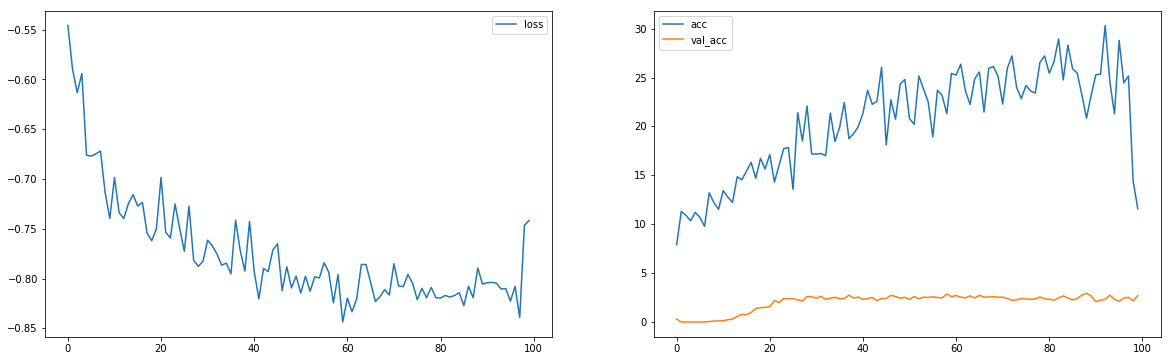

In [21]:
fig=plt.figure(figsize=(20, 6))
fig, axs = plt.subplots(1,2, figsize=(20, 6))
axs[1].plot(history.history['iou_score'], label='acc')
axs[1].plot(history.history['val_iou_score'],label='val_acc')

axs[1].legend()
axs[0].plot(history.history['loss'], label='loss')
# axs[0].plot(history.history['val_loss'],label='val_loss')

axs[0].legend()

In [ ]:
x, y = train_gen.__getitem__(0)
fig, axs = plt.subplots(1,2, figsize=(20, 20))
axs[0].imshow(x[0])
axs[1].imshow(y[0],cmap="gray")

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(checkPoint+'/best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]
    

In [ ]:
history = model.fit_generator(train_gen, 
                              validation_data=valid_gen,
                              steps_per_epoch=len(train_gen), 
                              validation_steps=len(valid_gen),
                              epochs=epochs,                              
                              callbacks=callbacks)
model.save_weights(r"backup\FPNresnet50-256_Models.h5")

In [22]:
x, y = valid_gen.__getitem__(10)

In [ ]:
result = model.predict(x)
result = result > 0.5

In [ ]:
plt.imshow(np.reshape(result[0,:,:,2], (image_size, image_size)), cmap="gray")

In [ ]:
plt.imshow(y[0,:,:,2], cmap="gray")

In [ ]:
def mask2rle(img, x):   
    img = np.reshape(img, (image_size, image_size))    
    mask = Image.fromarray(img).resize(size=(x[0],x[1]))
    img=np.array(mask)
    pixels = img.T.flatten()#Look at the image after transposing    
    pixels = np.concatenate([[0], pixels, [0]])    
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1    
    runs[1::2] -= runs[::2]
    return runs
    #print("runs=",runs)


In [ ]:
sub=pd.read_csv("sample_submission.csv")
sub["file_name"] = sub["filename_class"].str.split("_").str[0]+".jpeg"
sub["encoded_mask"]=sub["encoded_mask"].astype(str)
sub.head()

In [ ]:
def mask2rle(img):
    pixels = img.T.flatten()
    pixels = np.pad(pixels, ((1, 1), ))
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
path=r"J:\anadolu\Testing_Imgs\Testing_Imgs\\"    
for i,row in sub.iterrows():
    try:
        x = Image.open(path+sub.loc[i,"file_name"])
        img = np.array(x.resize((image_size,image_size)))
        img = np.expand_dims(img, axis=0)
        result = model.predict(img)
        result = result > 0.5
        index = int(row["filename_class"][-1])      
        result = np.reshape(result[0,:,:,index-1], (image_size,image_size))
        result = Image.fromarray(result).resize(size=(x.size[1],x.size[0]))
        result = np.array(result)
        a=mask2rle(result.round().astype(int))
        sub.at[i,"encoded_mask"]=a
        x.close()        
    except:
        pass


In [ ]:
sub=sub.drop(["file_name"], axis=1)
sub.to_csv("backup\sample_submission.csv", index=False)

In [ ]:
sub["encoded_mask"]=sub["encoded_mask"].astype(str)
sub.info()

In [ ]:
file=r"J:\anadolu\Testing_Imgs\Testing_Imgs\1f374b72-0953-42da-9919-843c765c1499.jpeg"
x = Image.open(file)
plt.imshow(x)
img=np.array(x.resize((image_size,image_size)))
img = np.expand_dims(img, axis=0)
print(img.shape)


In [ ]:
img = np.reshape(result[0,:,:,1], (256, 256))
mask = Image.fromarray(img).resize(size=(256,256))
img=np.array(mask)
plt.imshow(img)


In [ ]:
a=mask2rle(img.round().astype(int))

In [ ]:
sub=pd.read_csv("backup\sample_submission.csv")

In [ ]:
sub.info()